In [1132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler,RobustScaler
import xgboost as xgb
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import re
from collections import OrderedDict

In [1133]:
def model(classifier_name, X, y):
    print(classifier_name)
    print('data shape:{0}'.format(X.shape))
#     classifier = RandomForestClassifier(n_jobs=8,class_weight = {0: 1000, 1: 1})
#     classifier = RandomForestClassifier(n_jobs=2)
#     classifier = xgb.XGBClassifier(objective='binary:logistic', n_jobs=2)
    classifier = AdaBoostClassifier(learning_rate=0.1)
    # classifier = xgb.XGBClassifier(objective='binary:logistic', n_jobs=8,scale_pos_weight=0.1)
#     classifier = tree.DecisionTreeClassifier()
#     classifier = LogisticRegression()
    classifier.fit(X=X, y=y)
    # jl.dump(classifier,'{0}.joblib'.format(classifier_name))
    return classifier


def evaluate_performance(prefix, classifier, X, y):
    """
    :param classifier: Trained classifier
    :param X: array-like of shape (n_samples,n_features)
    :param y:array-like of shape (n_samples)
    :return: None
    """
    print(prefix)
    y_predict = classifier.predict(X)
    print('y_val counter:{0}'.format(Counter(y)))
    print('y_predict counter:{0}'.format(Counter(y_predict)))
    y_predict_proba = classifier.predict_proba(X)

    pos_count = len(y_predict[y_predict==1])
    tp = 0
    for i in range(len(y_predict)):
        if y.iloc[i]==1 and y.iloc[i]== y_predict[i]:
            tp = tp+1
    print('pos_count',pos_count,tp)

    target_names = ['class 0', 'class 1']
    accuracy = metrics.accuracy_score(y_true=y,y_pred=y_predict)
    precision = metrics.precision_score(y, y_pred=y_predict, average='macro')
    recall = metrics.recall_score(y,y_predict)
    print(classification_report(y_true=y, y_pred=y_predict))
    print('roc_auc_score:{0}'.format(metrics.roc_auc_score(y_true=y,y_score=y_predict)))
    metrics.plot_roc_curve(estimator=classifier, X=X, y=y)
    metrics.plot_confusion_matrix(classifier, X, y)
    print('accuracy:{0}'.format(accuracy))
    print('precision:{0}'.format(precision))
    print('recall:{0}'.format(recall))
    print(metrics.confusion_matrix(y,y_predict))



In [783]:
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower

# age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

# sibsp: The dataset defines family relations in this way...
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)

# parch: The dataset defines family relations in this way...
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them.

In [1134]:

train_path = 'train.csv'
test_path = 'test.csv'
df = pd.read_csv(train_path,sep=',')
df['Age'].fillna(0,inplace=True)
df['Fare'].fillna(0,inplace=True)
df['Name'].fillna('unknow',inplace=True)
df['Cabin'].fillna('unknow',inplace=True)
print(df.shape)
df.head()


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknow,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknow,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknow,S


In [1135]:
#按照客舱的分类字母编号分类
# print(Counter(df['Cabin']))
d = Counter(df['Cabin'])
d_by_c = {}
cs = []
for key,value in d.items():
    c = re.search('[a-zA-Z]',key).group()
    cs.append(c)
cs = Counter(cs)
print(cs)
i = 1
for c,num in cs.items():
    cs[c] = i
    i+=1
print(cs)
cabins = []
for value in df['Cabin']:
    c = re.search('[a-zA-Z]',value).group()
    cabins.append(cs[c])
df.insert(10,'Cabins',cabins)
df.head()

Counter({'C': 42, 'B': 33, 'D': 25, 'E': 23, 'A': 15, 'F': 7, 'u': 1, 'G': 1, 'T': 1})
Counter({'T': 9, 'F': 8, 'B': 7, 'A': 6, 'D': 5, 'G': 4, 'E': 3, 'C': 2, 'u': 1})


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabins,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,1,unknow,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,1,unknow,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,2,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,1,unknow,S


In [1136]:
#统计每个姓出现的次数
last_names = [name.split(',')[1] for name in df['Name']]
last_name_d =  Counter(last_names)
last_name_sta = []
for last_name in last_names:
    num = last_name_d[last_name]
    last_name_sta.append(num)
df.insert(3,'last_name',last_name_sta)
df.head()

,PassengerId,Survived,Pclass,last_name,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabins,Cabin,Embarked
0,1,0,3,1,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,1,unknow,S
1,2,1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,2,C85,C
2,3,1,3,1,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,1,unknow,S
3,4,1,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,2,C123,S
4,5,0,3,4,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,1,unknow,S


In [1137]:
column = 'Embarked'
df[column].fillna('unknow',inplace=True)
d = Counter(df[column])
laEm = LabelEncoder()
labels = [key for key,value in d.items()]
print(labels)
laEm.fit(labels)
datas = laEm.transform(df[column])
df[column] = datas

column = 'Sex'
df[column].fillna('unknow',inplace=True)
d = Counter(df[column])
laSex = LabelEncoder()
labels = [key for key,value in d.items()]
print(labels)
laSex.fit(labels)
datas = laSex.transform(df[column])
df[column] = datas

column = 'Cabin'
df[column].fillna('unknow',inplace=True)
d = Counter(df[column])
laSex = LabelEncoder()
labels = [key for key,value in d.items()]
print(labels)
laSex.fit(labels)
datas = laSex.transform(df[column])
df[column] = datas


['S', 'C', 'Q', 'unknow']
['male', 'female']
['unknow', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24', 'C90', 'C45', 'E8', 'B101', 'D45', 'C46', 'D30

In [1038]:
# robs = RobustScaler()
# age = robs.fit_transform(df['Age'].values.reshape(-1,1))
# fare = robs.fit_transform(df['Fare'].values.reshape(-1,1))
# df.drop('Age',axis=1,inplace=True)
# df.drop('Fare',axis=1,inplace=True)
# df.insert(0,'Age',age)
# df.insert(1,'Fare',fare)
# df.head()

df.head()
print(df.shape)

(891, 14)


In [1138]:
fare_data = df['Fare']
q25,q75 = np.percentile(fare_data,25),np.percentile(fare_data,75)
print('q25',q25,'q75',q75)
iqr = q75 - q25
iqr_cut_off = iqr * 1.5
fare_down,fare_upper = q25 - iqr_cut_off,q75 + iqr_cut_off
outliers = [value for value in fare_data if value < fare_down or value > fare_upper]
print('length of outliers:{0}'.format(len(outliers)))
drop_index = df[(df['Fare'] > fare_upper) | (df['Fare'] < fare_down)].index
df.drop(drop_index,inplace=True)
print(df.shape)

q25 7.9104 q75 31.0
length of outliers:116
(775, 14)


Text(0.5, 1.0, 'Embarked vs Suvrived')

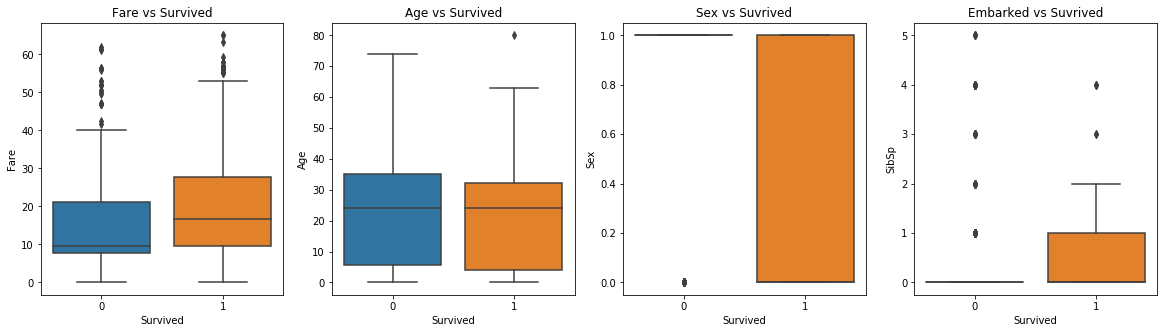

In [1139]:
fig,axes = plt.subplots(ncols=4,figsize=(20,5))
sns.boxplot(x='Survived',y='Fare',data=df,ax=axes[0])
axes[0].set_title('Fare vs Survived')

sns.boxplot(x='Survived',y='Age',data=df,ax=axes[1])
axes[1].set_title('Age vs Survived')

sns.boxplot(x='Survived',y='Sex',data=df,ax=axes[2])
axes[2].set_title('Sex vs Suvrived')

sns.boxplot(x='Survived',y='SibSp',data=df,ax=axes[3])
axes[3].set_title('Embarked vs Suvrived')


In [1140]:
# X,y = df.loc[:,['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']],df['Survived']
need_columns = ['Pclass','last_name','Sex','SibSp','Parch','Fare','Cabins','Cabin','Embarked']
X,y = df.loc[:,need_columns],df['Survived']
X.head()

,Pclass,last_name,Sex,SibSp,Parch,Fare,Cabins,Cabin,Embarked
0,3,1,1,1,0,7.2500,1,147,2
2,3,1,0,0,0,7.9250,1,147,2
3,1,1,0,1,0,53.1000,2,55,2
4,3,4,1,0,0,8.0500,1,147,2
5,3,7,1,0,0,8.4583,1,147,1


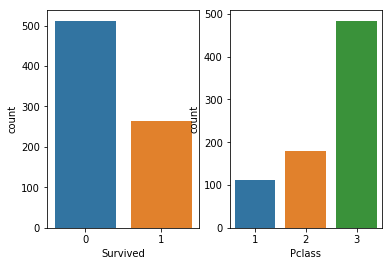

In [1141]:
fig = plt.figure()
fig.add_subplot(121)
sns.countplot(y)
fig.add_subplot(122)
sns.countplot(df['Pclass'])

# base line

X_tain: (620, 9)
X_test: (155, 9)
baseline
data shape:(620, 9)
baseline
y_val counter:Counter({0: 100, 1: 55})
y_predict counter:Counter({0: 99, 1: 56})
pos_count 56 38
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       100
           1       0.68      0.69      0.68        55

    accuracy                           0.77       155
   macro avg       0.75      0.76      0.75       155
weighted avg       0.78      0.77      0.77       155

roc_auc_score:0.7554545454545456
accuracy:0.7741935483870968
precision:0.7534271284271284
recall:0.6909090909090909
[[82 18]
 [17 38]]


/home/xiejh/miniconda2/envs/dj/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


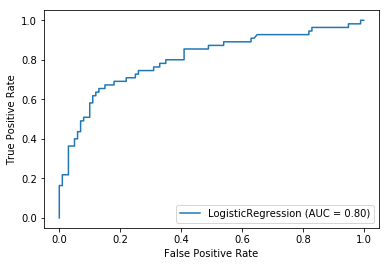

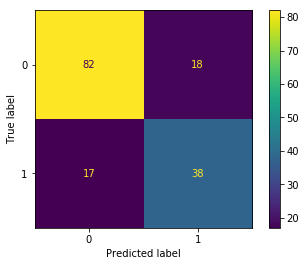

In [1143]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print('X_tain:',X_train.shape)
print('X_test:',X_test.shape)
#Evaluate performance of model using original data
classifier = model_v1('baseline',X_train,y_train)
evaluate_performance('baseline',classifier=classifier,X=X_test,y=y_test)

In [1144]:
test= pd.read_csv(test_path,sep=',')
test['Age'].fillna(0,inplace=True)
test['Fare'].fillna(0,inplace=True)
test['Name'].fillna('unknow',inplace=True)
test['Cabin'].fillna('unknow',inplace=True)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,unknow,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,unknow,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,unknow,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,unknow,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,unknow,S


In [1145]:

#按照客舱的分类字母编号分类
print(cs)
# print(Counter(df['Cabin']))
# d = Counter(test['Cabin'])
# d_by_c = {}
# cs = []
# for key,value in d.items():
#     c = re.search('[a-zA-Z]',key).group()
#     cs.append(c)
# cs = Counter(cs)
# print(cs)
# i = 1
# for c,num in cs.items():
#     cs[c] = i
#     i+=1
# print(cs)
cabins = []
for value in test['Cabin']:
    c = re.search('[a-zA-Z]',value).group()
    cabins.append(cs[c])
test.insert(9,'Cabins',cabins)
test.head()

Counter({'T': 9, 'F': 8, 'B': 7, 'A': 6, 'D': 5, 'G': 4, 'E': 3, 'C': 2, 'u': 1})


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabins,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,1,unknow,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,1,unknow,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,1,unknow,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,1,unknow,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,1,unknow,S


In [1146]:
#统计每个姓出现的次数
last_names = [name.split(',')[1] for name in test['Name']]
last_name_d =  Counter(last_names)
last_name_sta = []
for last_name in last_names:
    num = last_name_d[last_name]
    last_name_sta.append(num)
test.insert(2,'last_name',last_name_sta)
test.head()

,PassengerId,Pclass,last_name,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabins,Cabin,Embarked
0,892,3,2,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,1,unknow,Q
1,893,3,1,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,1,unknow,S
2,894,2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,1,unknow,Q
3,895,3,1,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,1,unknow,S
4,896,3,1,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,1,unknow,S


In [1147]:
# X,y = df.loc[:,['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']],df['Survived']
print(need_columns)
df_test = test.loc[:,need_columns]
df_test.head()

['Pclass', 'last_name', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabins', 'Cabin', 'Embarked']


,Pclass,last_name,Sex,SibSp,Parch,Fare,Cabins,Cabin,Embarked
0,3,2,male,0,0,7.8292,1,unknow,Q
1,3,1,female,1,0,7.0000,1,unknow,S
2,2,2,male,0,0,9.6875,1,unknow,Q
3,3,1,male,0,0,8.6625,1,unknow,S
4,3,1,female,1,1,12.2875,1,unknow,S


In [1148]:
column = 'Embarked'
df_test[column].fillna('unknow',inplace=True)
d = Counter(df_test[column])
laEm = LabelEncoder()
labels = [key for key,value in d.items()]
print(labels)
laEm.fit(labels)
datas = laEm.transform(df_test[column])
df_test[column] = datas

column = 'Sex'
df_test[column].fillna('unknow',inplace=True)
d = Counter(df_test[column])
laSex = LabelEncoder()
labels = [key for key,value in d.items()]
print(labels)
laSex.fit(labels)
datas = laSex.transform(df_test[column])
df_test[column] = datas

column = 'Cabin'
df_test[column].fillna('unknow',inplace=True)
d = Counter(df_test[column])
laSex = LabelEncoder()
labels = [key for key,value in d.items()]
print(labels)
laSex.fit(labels)
datas = laSex.transform(df_test[column])
df_test[column] = datas

['Q', 'S', 'C']
['male', 'female']
['unknow', 'B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78', 'D34', 'D19', 'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61', 'C53', 'D43', 'C130', 'C132', 'C101', 'C55 C57', 'B71', 'C46', 'C116', 'F', 'A29', 'G6', 'C6', 'C28', 'C51', 'E46', 'C54', 'C97', 'D22', 'B10', 'F4', 'E45', 'E52', 'D30', 'B58 B60', 'E34', 'C62 C64', 'A11', 'B11', 'C80', 'F33', 'C85', 'D37', 'C86', 'D21', 'C89', 'F E46', 'A34', 'D', 'B26', 'C22 C26', 'B69', 'C32', 'B78', 'F E57', 'F2', 'A18', 'C106', 'B51 B53 B55', 'D10 D12', 'E60', 'E50', 'E39 E41', 'B52 B54 B56', 'C39', 'B24', 'D28', 'B41', 'C7', 'D40', 'D38', 'C105']


In [1149]:
y_pred = classifier.predict(df_test)
output = pd.DataFrame({'PassengerId':test['PassengerId'].values,'Survived':y_pred})
output.to_csv('submission.csv',sep=',',index=None)

In [1121]:
AdaBoostClassifier??